# unet implimentation in renetal vessel dataset

In [601]:
!pip install numpy==1.16.4

In [602]:
import numpy as np

seed=42

np.random.seed = seed

In [603]:
from sklearn.model_selection import train_test_split
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.transform import resize
from keras import regularizers

from keras.models import Model, load_model
from keras.layers import Input,UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D,MaxPool2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler
from keras import backend as K
import tensorflow as tf
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.io import imread
import numpy as np
from keras.callbacks import History
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score


print('okay')

okay


In [604]:
# Set some parameters
height = 32*16
width = 32*16
IMG_CHANNELS = 1

seed = 42

In [605]:
#mask=np.load(r'../input/brats-2013/npy_file_t1c/npy_file_t1c/dataset/dataset.npy',allow_pickle=True)#
#dataset=np.load(r'../input/brats-2013/npy_file_t1c/npy_file_t1c/masks/mask.npy',allow_pickle=True)

In [606]:
def add_colored_dilate(image, mask_image, dilate_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    dilate_image_gray = cv2.cvtColor(dilate_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    dilate = cv2.bitwise_and(dilate_image, dilate_image, mask=dilate_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])
    dilate_coord = np.where(dilate!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]

    ret = cv2.addWeighted(image, 0.7, dilate, 0.3, 0)
    ret = cv2.addWeighted(ret, 0.7, mask, 0.3, 0)

    return ret

def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret

In [607]:
path_img=r'../input/tumor/tumor/image/image/*.png'
path_mask=r'../input/tumor/tumor/mask/mask/*.png'

In [608]:
pngs_img=glob(path_img)

pngs_mask=glob(path_mask)

In [609]:
len(pngs_img),len(pngs_mask)

(3064, 3064)

In [610]:
x_data=[]

y_data=[]
    
no=10

for i in range(100*no):
    img=cv2.imread(pngs_img[i],0)
    img=cv2.resize(img,(width,height))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    x_data.append(img)
    
    mask=cv2.imread(pngs_mask[i],0)
    mask=cv2.resize(mask,(width,height))
    mask = (mask - np.min(mask)) / (np.max(mask) - np.min(mask))
    y_data.append(mask)

In [611]:
x_data=np.array(x_data)

y_data=np.array(y_data)

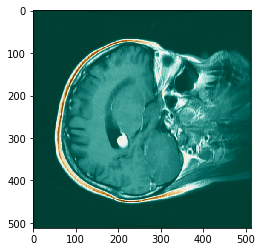

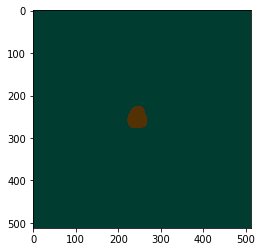

In [612]:
plt.imshow(x_data[10],cmap='BrBG')
plt.show()

plt.imshow(y_data[10],cmap='BrBG')
plt.show()

In [613]:
x_data = x_data.reshape(-1,height,width,1)
y_data = y_data.reshape(-1,height,width,1)

In [614]:
#x_data = x_data[:,:,:,np.newaxis]
#y_data = y_data[:,:,:,np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.5)

In [615]:
x_train[1].shape

(512, 512, 1)

In [616]:
y_data.shape

(1000, 512, 512, 1)

In [617]:
batchsize=8*2

print('okay')

okay


In [618]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

print('okay')

okay


In [619]:
def jaccard (y_true, y_pred):
    return jaccard_score(y_true,y_pred,average='binary')

In [620]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [621]:
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [622]:
# Build U-Net model
inputs = Input(shape=(height,width,1))
'''s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.00001),
            kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(rate=0.1) (c1)
c1 = Conv2D(8, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.00001),
            kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.00001),
            kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(rate=0.1) (c2)
c2 = Conv2D(16, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.00001),
            kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.00001),
            kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(rate=0.2) (c3)
c3 = Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.00001),
            kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.00001),
            kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(rate=0.2) (c4)
c4 = Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.00001),
            kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.00001),
            kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(rate=0.3) (c5)
c5 = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.00001),
            kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.00001),
            kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(rate=0.2) (c6)
c6 = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.00001),
            kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001),
            kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(rate=0.2) (c7)
c7 = Conv2D(32, (3, 3), activation='elu', kernel_regularizer=regularizers.l2(0.00001),
            kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.00001),
            kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(rate=0.1) (c8)
c8 = Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.00001),
            kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.00001),
            kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(rate=0.1) (c9)
c9 = Conv2D(8, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.00001),
            kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = (Model(inputs=[inputs], outputs=[outputs]))

#model.summary()'''

c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(inputs, output_layer)

print('okay')

okay


In [623]:
import keras.backend as K


In [624]:
#pngs_mask[0]

In [625]:
#image_set[0].shape

In [626]:
#mask_set.shape

In [627]:
#image_set[0]

In [628]:
#image_set=np.expand_dims(image_set,axis=3)
#mask_set=np.expand_dims(mask_set,axis=3)

In [629]:
# Split train and valid
#X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X, X_feat, y, test_size=0.15, random_state=42)

In [630]:
# Normalize X_feat
#x_feat_mean = X_feat_train.mean(axis=0, keepdims=True)
#x_feat_std = X_feat_train.std(axis=0, keepdims=True)
#X_feat_train -= x_feat_mean
#X_feat_train /= x_feat_std

#X_feat_valid -= x_feat_mean
#X_feat_valid /= x_feat_std

In [631]:
#image_set.shape,mask_set.shape

In [632]:
#callbacks = [
    #EarlyStopping(patience=5, verbose=1),
    #ReduceLROnPlateau(patience=3, verbose=1),
    #ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True, save_weights_only=True)]

#results = model.fit({'img': X_train, 'feat': X_feat_train}, y_train, batch_size=16, epochs=50, callbacks=callbacks,
                    #validation_data=({'img': X_valid, 'feat': X_feat_valid}, y_valid))

In [633]:
model.compile(optimizer=Adam(2e-4),loss='binary_crossentropy', metrics=[dice_coef])

In [634]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=10,
                                   zoom_range=0.1)

In [635]:
from keras.callbacks import ReduceLROnPlateau,EarlyStopping

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 2,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

# we put our call backs into a callback list
callbacks = [earlystop, reduce_lr]

In [636]:
output =model.fit_generator(train_datagen.flow(x_train, y_train,batch_size=batchsize),
                            steps_per_epoch=200,callbacks=callbacks,validation_data=(x_val, y_val),
                            epochs=50,verbose=1,validation_steps=40,shuffle=True)

Epoch 1/50
200/200 [==============================] - 72s 362ms/step - loss: 0.1370 - dice_coef: 0.9578 - val_loss: 0.0858 - val_dice_coef: 0.9866
Epoch 2/50
200/200 [==============================] - 64s 322ms/step - loss: 0.0882 - dice_coef: 0.9816 - val_loss: 0.0827 - val_dice_coef: 0.9828
Epoch 3/50
200/200 [==============================] - 64s 322ms/step - loss: 0.0866 - dice_coef: 0.9819 - val_loss: 0.0820 - val_dice_coef: 0.9826
Epoch 4/50
200/200 [==============================] - 64s 321ms/step - loss: 0.0850 - dice_coef: 0.9820 - val_loss: 0.0821 - val_dice_coef: 0.9864
Epoch 5/50
200/200 [==============================] - 65s 323ms/step - loss: 0.0834 - dice_coef: 0.9819 - val_loss: 0.0773 - val_dice_coef: 0.9817
Epoch 6/50
200/200 [==============================] - 65s 326ms/step - loss: 0.0802 - dice_coef: 0.9822 - val_loss: 0.0763 - val_dice_coef: 0.9828
Epoch 7/50
200/200 [==============================] - 65s 324ms/step - loss: 0.0810 - dice_coef: 0.9819 - val_loss: 0.

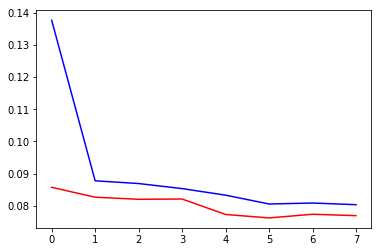

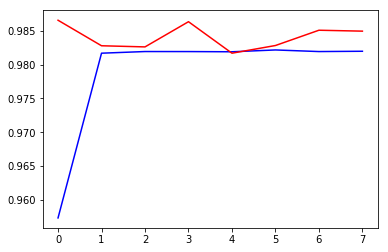

In [637]:
plt.plot(output.history['loss'], color='b')
plt.plot(output.history['val_loss'], color='r')
plt.show()
plt.plot(output.history['dice_coef'], color='b')
plt.plot(output.history['val_dice_coef'], color='r')
plt.show()

In [638]:
#model.evaluate({'img': X_valid, 'feat': X_feat_valid}, y_valid, verbose=1)


In [639]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
'''def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)
thres = np.linspace(0.25, 0.75, 20)
thres_ioc = [iou_metric_batch(y_valid, np.int32(preds_val > t)) for t in tqdm_notebook(thres)]'''

'def iou_metric(y_true_in, y_pred_in, print_table=False):\n    labels = y_true_in\n    y_pred = y_pred_in\n    \n    true_objects = 2\n    pred_objects = 2\n\n    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]\n\n    # Compute areas (needed for finding the union between all objects)\n    area_true = np.histogram(labels, bins = true_objects)[0]\n    area_pred = np.histogram(y_pred, bins = pred_objects)[0]\n    area_true = np.expand_dims(area_true, -1)\n    area_pred = np.expand_dims(area_pred, 0)\n\n    # Compute union\n    union = area_true + area_pred - intersection\n\n    # Exclude background from the analysis\n    intersection = intersection[1:,1:]\n    union = union[1:,1:]\n    union[union == 0] = 1e-9\n\n    # Compute the intersection over union\n    iou = intersection / union\n\n    # Precision helper function\n    def precision_at(threshold, iou):\n        matches = iou > threshold\n        true_positives = np.sum(matches,

In [640]:
print('training complete')

training complete


In [641]:
model.save_weights('u_net_weights.h5')

In [642]:
import cv2
import random

num=random.randint(0,10)

num=10

#name=r'../input/mri/mri/image/renamedimage/id_' + str(num) + '.png'

np.seterr(divide='ignore', invalid='ignore')

#test_img = cv2.imread(name,0)

test_img=x_data[num]

#test_img = test_img/np.max(test_img)

#test_image= image.img_to_array(test_image)

test_img = resize(test_img,(height,width,1))

test_img.shape

(512, 512, 1)

In [643]:
np.max(test_img)

1.0

In [644]:
test_img = np.expand_dims(test_img, axis=0)
test_img.shape

(1, 512, 512, 1)

In [645]:
results = model.predict(test_img,batch_size=None, verbose=0, steps=1)

results.shape

(1, 512, 512, 1)

In [646]:
from matplotlib import pyplot as plt

results=np.reshape(results,(height,width))

results.shape

(512, 512)

In [647]:
test_image=np.reshape(test_img,(height,width))

In [648]:
#name_actual_mask=r'../input/mri/mri/mask/markedrenamed/id_' + str(num) + '.png'

#actual_mask=cv2.imread(name_actual_mask)

actual_mask=y_data[num]

In [649]:
# Predict on train, val and test
'''preds_train = model.predict({'img': X_train, 'feat': X_feat_train}, verbose=1)
preds_val = model.predict({'img': X_valid, 'feat': X_feat_valid}, verbose=1)
preds_test = model.predict({'img': X_test, 'feat': X_feat_test}, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)'''

"preds_train = model.predict({'img': X_train, 'feat': X_feat_train}, verbose=1)\npreds_val = model.predict({'img': X_valid, 'feat': X_feat_valid}, verbose=1)\npreds_test = model.predict({'img': X_test, 'feat': X_feat_test}, verbose=1)\n\n# Threshold predictions\npreds_train_t = (preds_train > 0.5).astype(np.uint8)\npreds_val_t = (preds_val > 0.5).astype(np.uint8)\npreds_test_t = (preds_test > 0.5).astype(np.uint8)"

In [650]:
actual_mask.shape

(512, 512, 1)

In [651]:
op=results>0.01

In [652]:
#results=results*255

In [653]:
(np.unique(results))

array([0.9405991 , 0.94066155, 0.94068694, ..., 0.9999999 , 0.99999994,
       1.        ], dtype=float32)

10


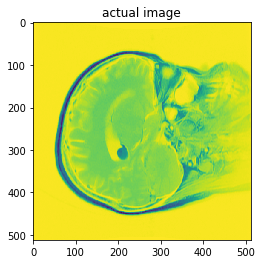

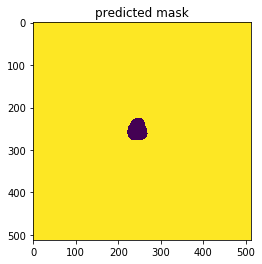

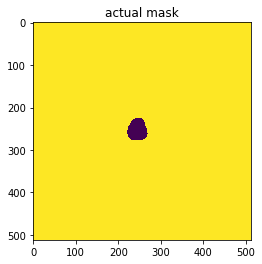

In [656]:
print(num)

plt.imshow(np.reshape(test_img,(512,512)))
plt.title('actual image')
plt.show()

plt.imshow(np.reshape(actual_mask,(512,512)))
plt.title('predicted mask')
plt.show()

plt.imshow(np.reshape(actual_mask,(512,512)))
plt.title('actual mask')
plt.show()

In [ ]:
#image = cv2.imread("../input/segmentation/test/CHNCXR_0003_0.png")
#predict_image = cv2.imread("../input/segmentation/test/CHNCXR_0003_0_predict.png")
#mask_image = cv2.imread("../input/segmentation/test/CHNCXR_0003_0_dilate.png")

image=image_set[num]
predict_image=results
mask_image=mask_set[num]

fig, axs = plt.subplots(4, 3, figsize=(16, 16))

axs[0, 0].set_title("Predicted")
axs[0, 0].imshow(add_colored_mask(image, predict_image))
axs[0, 1].set_title("Gold Std.")
axs[0, 1].imshow(add_colored_mask(image, mask_image))
axs[0, 2].set_title("Diff.")
axs[0, 2].imshow(diff_mask(mask_image, predict_image))

'''image=image_set[num]
predict_image=results
mask_image=mask_set[num]

axs[1, 0].set_title("Predicted")
axs[1, 0].imshow(add_colored_mask(image, predict_image))
axs[1, 1].set_title("Gold Std.")
axs[1, 1].imshow(add_colored_mask(image, mask_image))
axs[1, 2].set_title("Diff.")
axs[1, 2].imshow(diff_mask(mask_image, predict_image))

image=image_set[num]
predict_image=results
mask_image=mask_set[num]

axs[2, 0].set_title("Predicted")
axs[2, 0].imshow(add_colored_mask(image, predict_image))
axs[2, 1].set_title("Gold Std.")
axs[2, 1].imshow(add_colored_mask(image, mask_image))
axs[2, 2].set_title("Diff.")
axs[2, 2].imshow(diff_mask(mask_image, predict_image))

image=image_set[num]
predict_image=results
mask_image=mask_set[num]

axs[3, 0].set_title("Predicted")
axs[3, 0].imshow(add_colored_mask(image, predict_image))
axs[3, 1].set_title("Gold Std.")
axs[3, 1].imshow(add_colored_mask(image, mask_image))
axs[3, 2].set_title("Diff.")
axs[3, 2].imshow(diff_mask(mask_image, predict_image))'''